**1.   Model Running**

In [ ]:
"""

model.py
--------
This code sets up the model.

"""

#%% Imports from Python
from numpy import linspace,log
from types import SimpleNamespace

#%% Deterministic Growth Model with Public Capital.
class economy():
    '''

    Methods:
        __init__(self,**kwargs) -> Set the household's attributes.
        setup(self,**kwargs) -> Sets parameters.

    '''

    #%% Constructor.
    def __init__(self,**kwargs):
        '''

        This initializes the model.

        Optional kwargs:
            All parameters changed by setting kwarg.

        '''

        print('--------------------------------------------------------------------------------------------------')
        print('Model')
        print('--------------------------------------------------------------------------------------------------\n')
        print('   The model is the deterministic growth model with public capital.')

        print('\n--------------------------------------------------------------------------------------------------')
        print('Household')
        print('--------------------------------------------------------------------------------------------------\n')
        print('   The household is infintely-lived and maximizes its lifetime utility from consumption.')
        print('    -> He/she can saves capital, which is used in production, for next period.')
        print('    -> He/she receives a dividend from the firm in the economy.')
        print('    -> He/she pays income tax to the government.')
        print('    -> He/she takes prices as given.')

        print('\n--------------------------------------------------------------------------------------------------')
        print('Firm')
        print('--------------------------------------------------------------------------------------------------\n')
        print('   The firm is infintely-lived and maximizes profit.')
        print('    -> It takes public capital as an input.')
        print('    -> It takes prices as given.')

        print('\n--------------------------------------------------------------------------------------------------')
        print('Government')
        print('--------------------------------------------------------------------------------------------------\n')
        print('   The government is infintely-lived and balances its budget.')
        print('    -> It taxes labor and capital income from the households.')
        print('    -> It spends on public capital.')

    #%% Set up model.
    def setup(self,**kwargs):
        '''

        This sets the parameters and creates the grids for the model.

            Input:
                self : Model class.
                kwargs : Values for parameters if not using the default.

        '''

        # Namespace for parameters, grids, and utility function.
        setattr(self,'par',SimpleNamespace())
        par = self.par

        print('\n--------------------------------------------------------------------------------')
        print('Parameters:')
        print('--------------------------------------------------------------------------------\n')

        # Preferences.
        par.beta = 0.96 # Discount factor.
        par.sigma = 2.00 # CRRA.

        # Demographics.
        par.N = 100 # Population.

        # Prices.
        par.r = 0.05 # Real interest rate.
        par.w = 9.70 # Real wage rate.

        # Technology.
        par.lambd = 0.05 # Public capital's weight in production.
        par.gamma = 1.00 # Wastefulness parameter.
        par.alpha = 0.33 # Capital's share of income.
        par.deltap = 0.08 # Depreciation rate of private capital.
        par.deltag = 0.05 # Depreciation rate of public capital.

        # Set up private capital grid.
        par.klen = 300 # Grid size for k.
        par.kmax = 50.0 # Upper bound for k.
        par.kmin = 0.001 # Minimum k.

        # Set up grid for public capital and tax rates.
        par.glen = par.klen

        # Update parameter values to kwarg values if you don't want the default values.
        for key,val in kwargs.items():
            setattr(par,key,val)

        assert par.beta > 0 and par.beta < 1.00
        assert par.sigma >= 1.00
        assert par.lambd > 0 and par.lambd < 1.00
        assert par.gamma > 0 and par.gamma <= 1.00
        assert par.alpha > 0 and par.alpha < 1.00
        assert par.deltap >= 0 and par.deltap <= 1.00
        assert par.deltag >= 0 and par.deltag <= 1.00
        assert par.klen > 5
        assert par.kmax > par.kmin

        # Set up private capital grid per capita.
        par.kgrid = linspace(par.kmin,par.kmax,par.klen)/par.N # Equally spaced, linear grid for kp (and kp').

        # Set up aggregate public capital grid.
        par.G = linspace(par.kmin,par.kmax,par.glen) # Equally spaced, linear grid for kg (and kg').

        # Set up tax rate grid.
        par.tau = linspace(0.0,1.0,par.glen) # Equally spaced, linear grid for tau.

        # Utility function.
        par.util = utility

        print('beta: ',par.beta)
        print('sigma: ',par.sigma)
        print('kmin: ',par.kmin)
        print('kmax: ',par.kmax)
        print('alpha: ',par.alpha)
        print('deltap: ',par.deltap)
        print('deltag: ',par.deltag)

#%% CRRA Utility Function.
def utility(c,sigma):

    # CRRA utility
    if sigma == 1:
        u = log(c) # Log utility.
    else:
        u = (c**(1-sigma))/(1-sigma) # CRRA utility.

    return u

In [ ]:
"""

solve.py
--------
This code solves the model.

"""

#%% Imports from Python
from numpy import argmax,expand_dims,inf,max,squeeze,unravel_index,zeros,seterr
from numpy.linalg import norm
from types import SimpleNamespace
import time
seterr(divide='ignore')
seterr(invalid='ignore')

#%% Solve the model using VFI.
def live_life_as_normal(myClass):
    '''

    This function solves the deterministic growth model with public capital.

    Input:
        myClass : Model class with parameters, grids, and utility function.

    '''

    print('\n--------------------------------------------------------------------------------------------------')
    print('Solving the Model by Value Function Iteration')
    print('--------------------------------------------------------------------------------------------------\n')

    # Namespace for optimal policy funtions.
    setattr(myClass,'sol',SimpleNamespace())
    sol = myClass.sol

    # Model parameters, grids and functions.
    par = myClass.par # Parameters.

    beta = par.beta # Discount factor.
    sigma = par.sigma # CRRA.

    N = par.N # Population size.

    r = par.r # Real interest rate.
    w = par.w # Real wage rate.

    lambd = par.lambd # Public capital's weight in production.
    gamma = par.gamma # Wastefulness parameter.
    alpha = par.alpha # Capital's share of income.
    deltap = par.deltap # Depreciation rate of private capital.
    deltag = par.deltag # Depreciation rate of public capital.

    klen = par.klen # Grid size for k.
    kgrid = par.kgrid # Grid for kp (state and choice).

    glen = par.glen # Grid size for kg.
    G = par.G # Grid for kg.
    tau = par.tau # Grid for tau.

    util = par.util # Utility function.

    # Value Function Iteration.
    v0 = zeros((klen,glen)) # Guess of value function for each value of k.

    crit = 1e-6;
    maxiter = 10000;
    diff = 1;
    iter = 0;

    t0 = time.time()

    while (diff > crit) and (iter < maxiter): # Iterate on the Bellman Equation until convergence.

        v1 = zeros((klen,glen)) # Container for V.
        y1 = zeros((klen,glen)) # Container for y.
        c1 = zeros((klen,glen)) # Container for c.
        ip1 = zeros((klen,glen)) # Container for ip'.
        ig1 = zeros((klen,glen)) # Container for ig'.
        kp1 = zeros((klen,glen)) # Container for kp'.
        kg1 = zeros((klen,glen)) # Container for kg'.
        tau1 = zeros((klen,glen)) # Container for tau.

        for g in range(0,glen): # Loop over the kg-states.
            for p in range(0,klen): # Loop over the kp-states.

                # Prices.
                r = alpha*(G[g]**lambd)*(kgrid[p]**(alpha-1))
                w = (1-alpha)*(G[g]**lambd)*(kgrid[p]**alpha)

                # Household's problem.
                y = (G[g]**lambd)*(kgrid[p]**alpha) # Output given kp and kg.
                ip = kgrid-((1-deltap)*kgrid[p]) # Possible values for investment given private capital.
                ip[ip<0.0] = 0.0
                c = ((1-tau[g])*(w+r*kgrid[p]))-ip # Possible values for consumption given investment, prices, the tax rate, and private capital.
                c[c<0.0] = 0.0

                # Solve the maximization problem.
                vall = squeeze(util(c,sigma) + beta*v0[:,g]) # Compute the value function for each choice of k'.
                vall[c<=0.0] = -inf # Set the value function to negative infinity number when c <= 0.

                vmax = max(vall) # Maximize: vmax is the maximized value function.
                pp,gg = unravel_index(argmax(vmax),(klen,glen))
                v1[p,g] = vmax
                y1[p,g] = y
                c1[p,g] = c[argmax(vall)] # Optimal c.
                ip1[p,g] = ip[argmax(vall)] # Optimal ip.
                ig1[p,g] = tau[g]*(w+r*kgrid[p]) # Optimal ig.
                kp1[p,g] = kgrid[argmax(vall)] # Optimal kp.
                if ip[argmax(vall)] == 0.0:
                    kp1[p,g] = (1-deltap)*kgrid[p]
                kg1[p,g] = gamma*(1-deltag)*G[g]+tau[g]*(w+r*kgrid[p]) # Optimal kg.
                tau1[p,g] = tau[g] # Optimal tax rate.

        diff = norm(v1-v0) # Check convergence.
        v0 = v1; # Update guess.

        iter = iter + 1; # Update counter.

        # Print counter.
        if iter%25 == 0:
            print('Iteration: ',iter,'.\n')

    t1 = time.time()
    print('Elapsed time is ',t1-t0,' seconds.')
    print('Converged in ',iter,' iterations.')

    # Macro variables, value, and policy functions.
    sol.v = v1 # Value function.
    sol.y = y1 # Output.
    sol.c = c1 # Consumption policy function.
    sol.ip = ip1*N # Private investment policy function.
    sol.ig = ig1 # Public investment policy function.
    sol.kp = kp1*N # Private capital policy function.
    sol.kg = kg1 # Public capital policy function.
    sol.tau = tau1 # Tax Rate.

In [ ]:
"""

my_graph.py
-----------
This code plots the value and policy functions.

"""

#%% Imports from Python
from matplotlib.pyplot import figure,plot,xlabel,ylabel,title,show

#%% Plot the model functions.
def track_public_capital(myClass):
    '''

    This function plots the model functions.

    Input:
        myClass : Model class with parameters, grids, utility function, and policy functions.

    '''

    # Model parameters, policy and value functions, and simulations.
    par = myClass.par # Parameters.
    sol = myClass.sol # Policy functions.

    # Output policy function.

    figure(1)
    plot(par.kgrid,sol.y)
    xlabel('$kp_{t}$')
    ylabel('$y_{t}$')
    title('Output Function')

    # Consumption policy function.

    figure(2)
    plot(par.kgrid,sol.c)
    xlabel('$kp_{t}$')
    ylabel('$c_{t}$')
    title('Consumption Function')

    # Private investment policy function.

    figure(3)
    plot(par.kgrid,sol.ip)
    xlabel('$kp_{t}$')
    ylabel('$ip_{t}$')
    title('Private Investment Policy Function')

    # Public investment policy function.

    figure(4)
    plot(par.kgrid,sol.ig)
    xlabel('$kp_{t}$')
    ylabel('$ig_{t}$')
    title('Public Investment Policy Function')

    # Private capital policy function.

    figure(5)
    plot(par.kgrid,sol.kp)
    xlabel('$kp_{t}$')
    ylabel('$kp_{t+1}$')
    title('Private Capital Policy Function')

    # Public capital policy function.

    figure(6)
    plot(par.kgrid,sol.kg)
    xlabel('$kp_{t}$')
    ylabel('$kg_{t+1}$')
    title('Public Capital Policy Function')

    # Plot Tax Rates.

    figure(7)
    plot(par.kgrid,sol.tau)
    xlabel('$kp_{t}$')
    ylabel('$tau_t$')
    title('Tax Rate')

    # Plot value function.

    figure(9)
    plot(par.kgrid,sol.v)
    xlabel('$kp_{t}$')
    ylabel('$V_t(k_t)$')
    title('Value Function')

    #show()

--------------------------------------------------------------------------------------------------
Model
--------------------------------------------------------------------------------------------------

   The model is the deterministic growth model with public capital.

--------------------------------------------------------------------------------------------------
Household
--------------------------------------------------------------------------------------------------

   The household is infintely-lived and maximizes its lifetime utility from consumption.
    -> He/she can saves capital, which is used in production, for next period.
    -> He/she receives a dividend from the firm in the economy.
    -> He/she pays income tax to the government.
    -> He/she takes prices as given.

--------------------------------------------------------------------------------------------------
Firm
----------------------------------------------------------------------------------------------

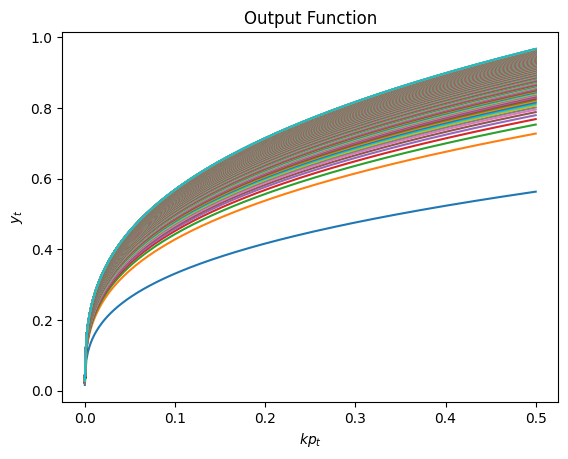

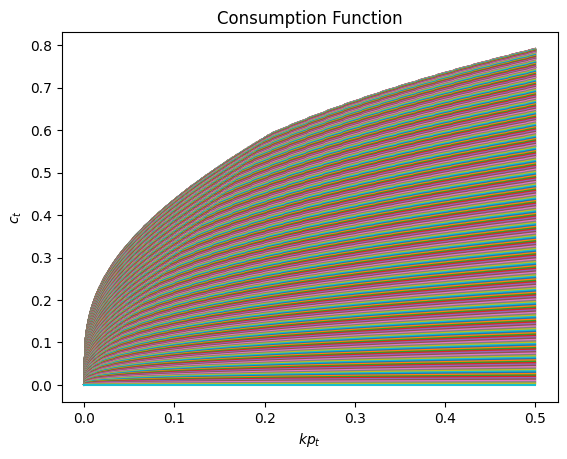

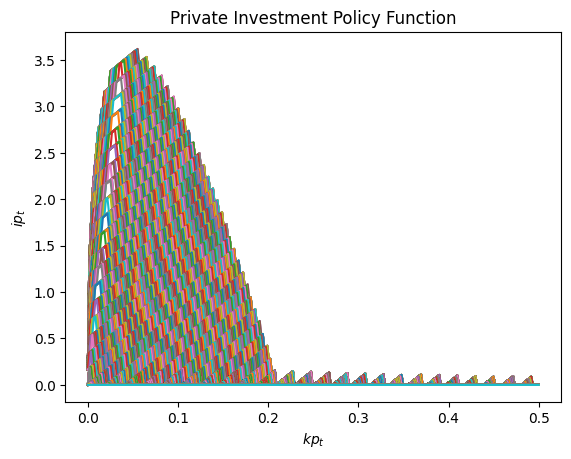

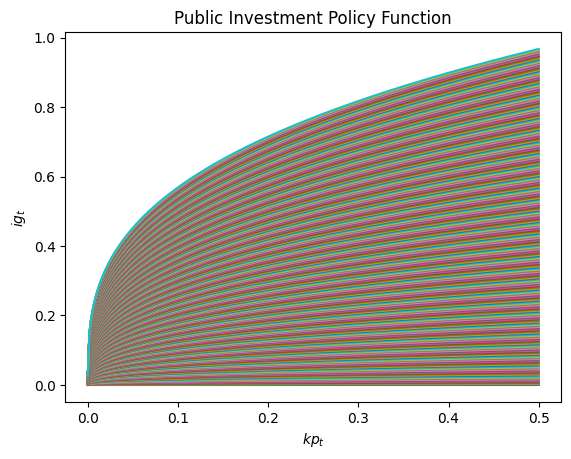

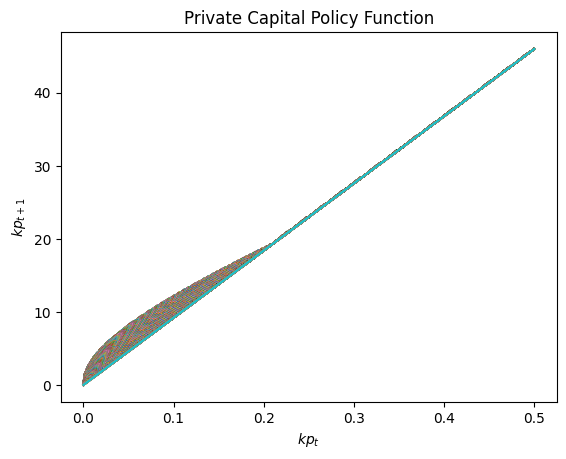

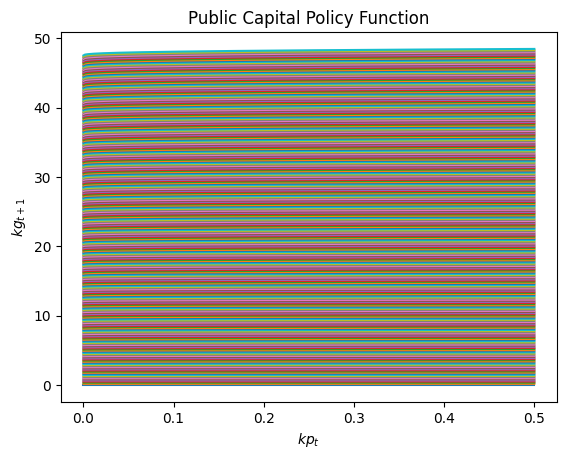

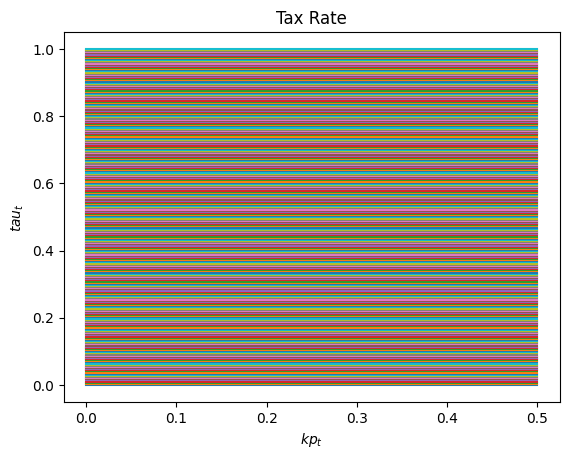

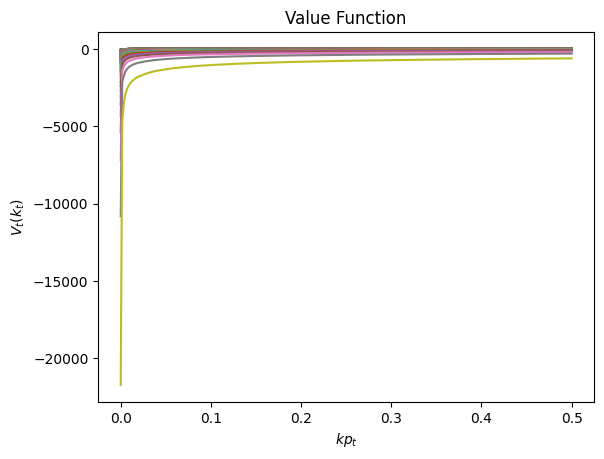

In [ ]:
"""

run_vfi_dgm.py
--------------
This code solves the deterministic growth model with public capital using value function iteration.

"""

#%% Import from Python and set project directory
# import os
# os.chdir("C:\\Users\\xmgb\\Dropbox\\02_FUV\\teaching\\spring_2025\\dynamic_macro\\notes\\code\\cubas")
# main = os.getcwd()
#figout = main+"\\output\\figures"

#%% Import from folder
# from model import economy
# from solve import live_life_as_normal
# from my_graph import track_public_capital

#%% Deterministic Growth Model with Public Capital.
market_forces = economy()

# Set the parameters, state space, and utility function.
market_forces.setup() # You can set the parameters here or use the defaults.

# Solve the model.
live_life_as_normal(market_forces) # Obtain the policy functions.

# Graphs.
track_public_capital(market_forces) # Plot policy functions.


**2. Change In Tax Rate**

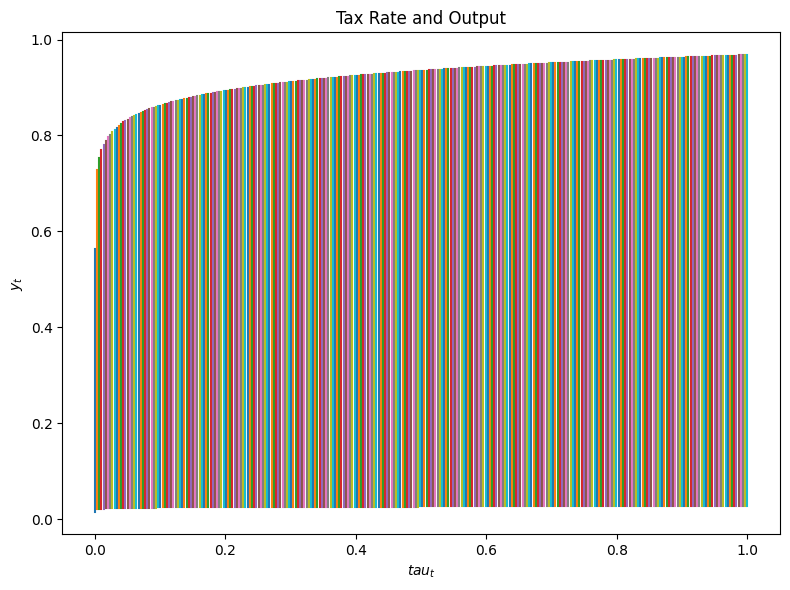

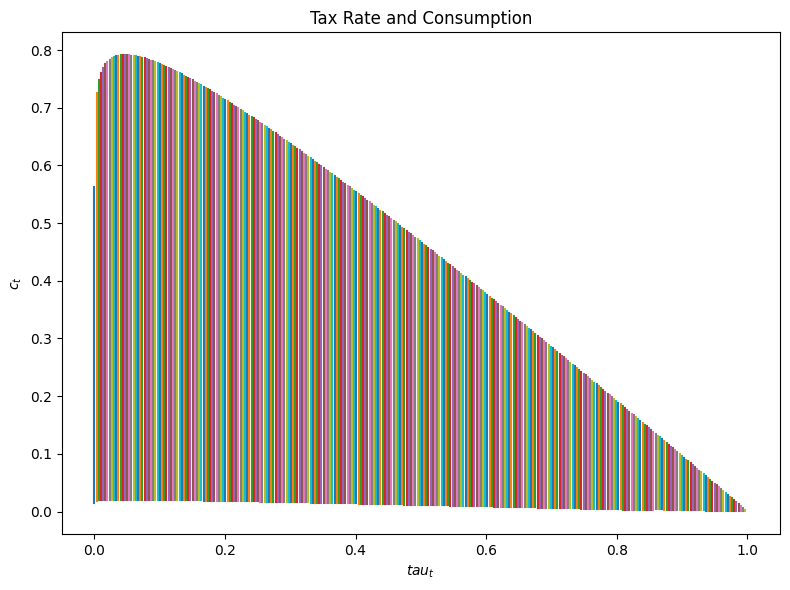

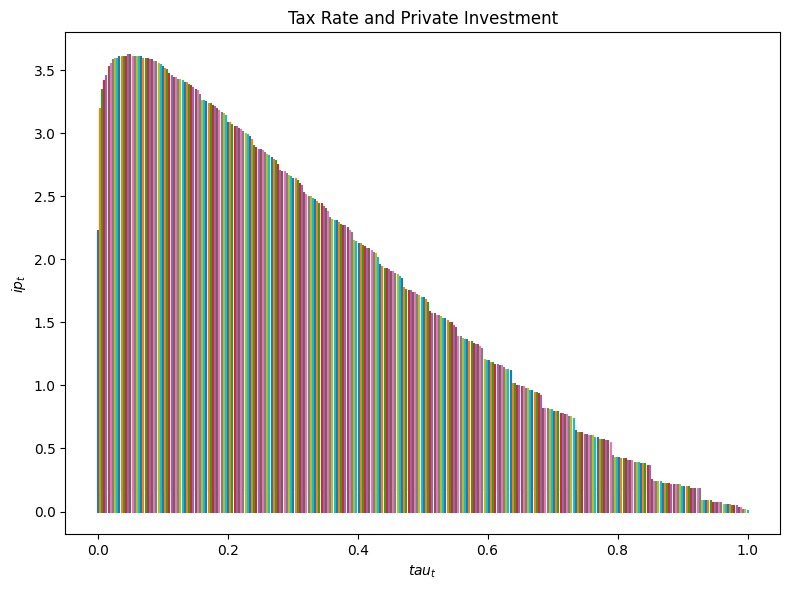

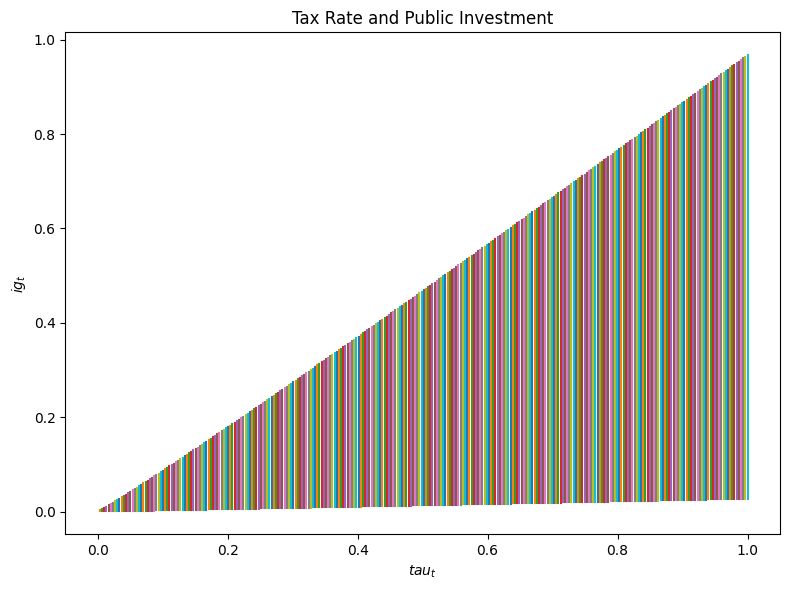

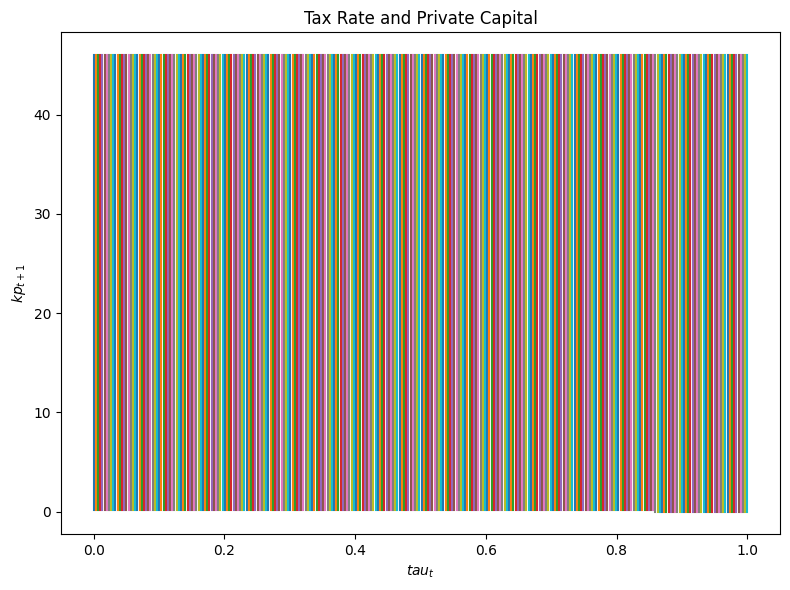

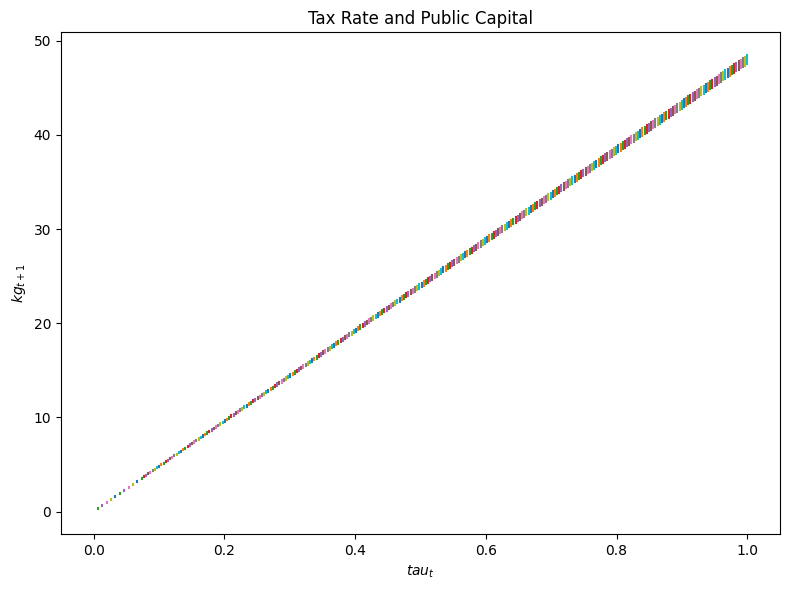

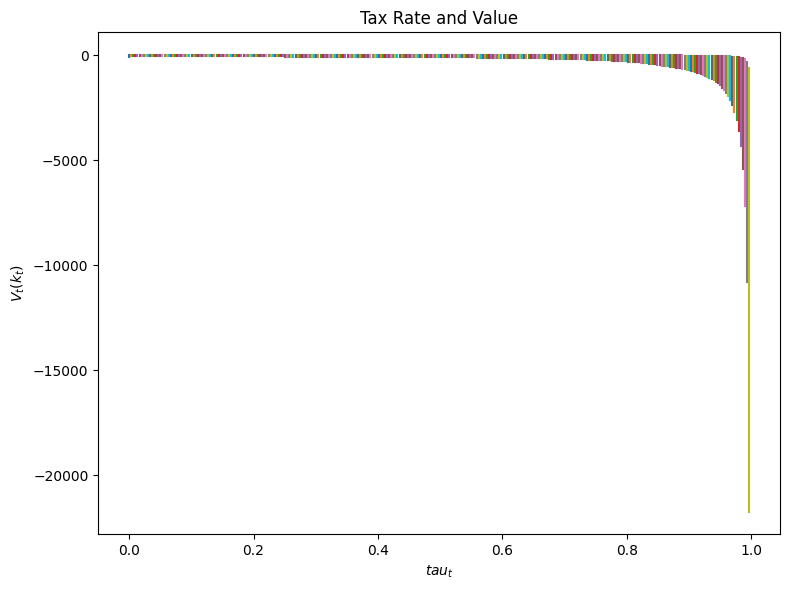

In [ ]:
"""

track_tax_rate.py
-----------
This code plots all policy functions in responses to changes in tax rate.

"""

import matplotlib.pyplot as plt
import contextlib
import io

def track_tax_rate(myClass):

    par = myClass.par
    sol = myClass.sol

    policy_names = [
        'Output Function',
        'Consumption Function',
        'Private Investment Policy Function',
        'Public Investment Policy Function',
        'Private Capital Policy Function',
        'Public Capital Policy Function',
        'Value Function'
    ]

    for policy_name in policy_names:  # Loop through each policy function name
        fig, ax = plt.subplots(figsize=(8, 6))  # Create a figure and axis for each plot

        if policy_name == 'Output Function':
            ax.plot(sol.tau, sol.y)  # Plot y against tau
            ax.set_title('Tax Rate and Output')
            ax.set_xlabel('$tau_t$')  # Set x-axis label to tau
            ax.set_ylabel('$y_{t}$')

        elif policy_name == 'Consumption Function':
            ax.plot(sol.tau, sol.c)
            ax.set_title('Tax Rate and Consumption')
            ax.set_xlabel('$tau_t$')
            ax.set_ylabel('$c_{t}$')

        elif policy_name == 'Private Investment Policy Function':
            ax.plot(sol.tau, sol.ip)
            ax.set_title('Tax Rate and Private Investment')
            ax.set_xlabel('$tau_t$')
            ax.set_ylabel('$ip_{t}$')

        elif policy_name == 'Public Investment Policy Function':
            ax.plot(sol.tau, sol.ig)
            ax.set_title('Tax Rate and Public Investment')
            ax.set_xlabel('$tau_t$')
            ax.set_ylabel('$ig_{t}$')

        elif policy_name == 'Private Capital Policy Function':
            ax.plot(sol.tau, sol.kp)
            ax.set_title('Tax Rate and Private Capital')
            ax.set_xlabel('$tau_t$')
            ax.set_ylabel('$kp_{t+1}$')

        elif policy_name == 'Public Capital Policy Function':
            ax.plot(sol.tau, sol.kg)
            ax.set_title('Tax Rate and Public Capital')
            ax.set_xlabel('$tau_t$')
            ax.set_ylabel('$kg_{t+1}$')

        elif policy_name == 'Value Function':
            ax.plot(sol.tau, sol.v)
            ax.set_title('Tax Rate and Value')
            ax.set_xlabel('$tau_t$')
            ax.set_ylabel('$V_t(k_t)$')

        plt.tight_layout()  # Adjust subplot parameters for a tight layout
        plt.show()  # Display the plot

# Silence print outputs and run the model
with contextlib.redirect_stdout(io.StringIO()):
    market_forces.setup()
    live_life_as_normal(market_forces)

# Generate the plots with tax rate on the x-axis
track_tax_rate(market_forces)

**3. Change In Gamma**

In [ ]:
def track_public_capital(myClass, axs, gamma_val):

    par = myClass.par
    sol = myClass.sol

    # Access the single axis within the list
    ax = axs[0]  # Get the single axis from the list

    # Plot using the single axis
    if policy_name == 'Output Function':
        ax.plot(par.kgrid, sol.y)
        ax.set_title(f'Output Function (γ = {gamma_val})')
        ax.set_xlabel('$kp_{t}$')
        ax.set_ylabel('$y_{t}$')
    elif policy_name == 'Consumption Function':
        ax.plot(par.kgrid, sol.c)
        ax.set_title(f'Consumption Function (γ = {gamma_val})')
        ax.set_xlabel('$kp_{t}$')
        ax.set_ylabel('$c_{t}$')
    elif policy_name == 'Private Investment Policy Function':
        ax.plot(par.kgrid, sol.ip)
        ax.set_title(f'Private Investment Policy Function (γ = {gamma_val})')
        ax.set_xlabel('$kp_{t}$')
        ax.set_ylabel('$ip_{t}$')
    elif policy_name == 'Public Investment Policy Function':
        ax.plot(par.kgrid, sol.ig)
        ax.set_title(f'Public Investment Policy Function (γ = {gamma_val})')
        ax.set_xlabel('$kp_{t}$')
        ax.set_ylabel('$ig_{t}$')
    elif policy_name == 'Private Capital Policy Function':
        ax.plot(par.kgrid, sol.kp)
        ax.set_title(f'Private Capital Policy Function (γ = {gamma_val})')
        ax.set_xlabel('$kp_{t}$')
        ax.set_ylabel('$kp_{t+1}$')
    elif policy_name == 'Public Capital Policy Function':
        ax.plot(par.kgrid, sol.kg)
        ax.set_title(f'Public Capital Policy Function (γ = {gamma_val})')
        ax.set_xlabel('$kp_{t}$')
        ax.set_ylabel('$kp_{t+1}$')
    elif policy_name == 'Tax Rate':
        ax.plot(par.kgrid, sol.tau)
        ax.set_title(f'Tax Rate (γ = {gamma_val})')
        ax.set_xlabel('$kp_{t}$')
        ax.set_ylabel('$tau_t$')
    elif policy_name == 'Value Function':
        ax.plot(par.kgrid, sol.v)
        ax.set_title(f'Value Function (γ = {gamma_val})')
        ax.set_xlabel('$kp_{t}$')
        ax.set_ylabel('$V_t(k_t)$')

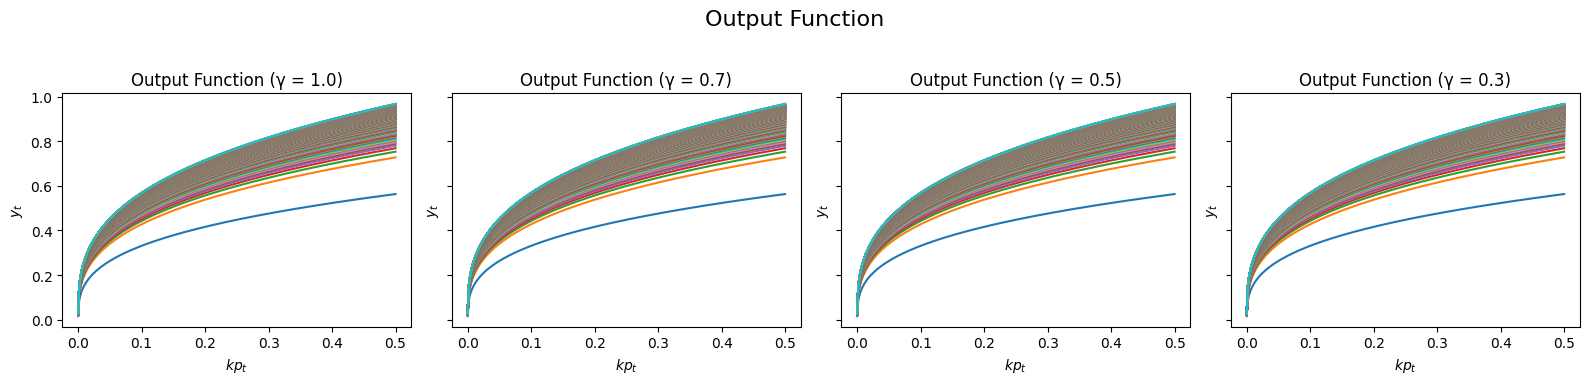

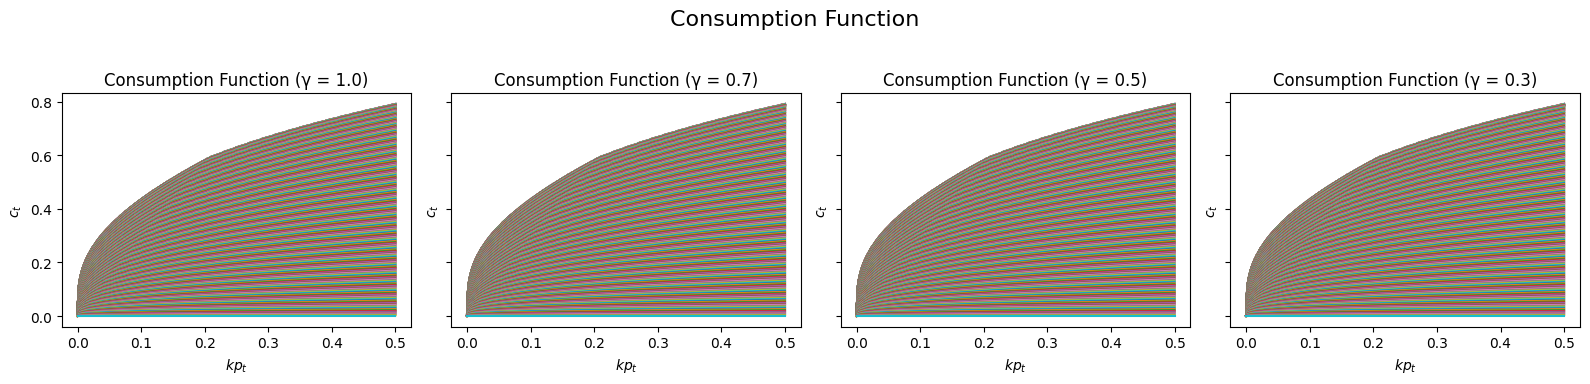

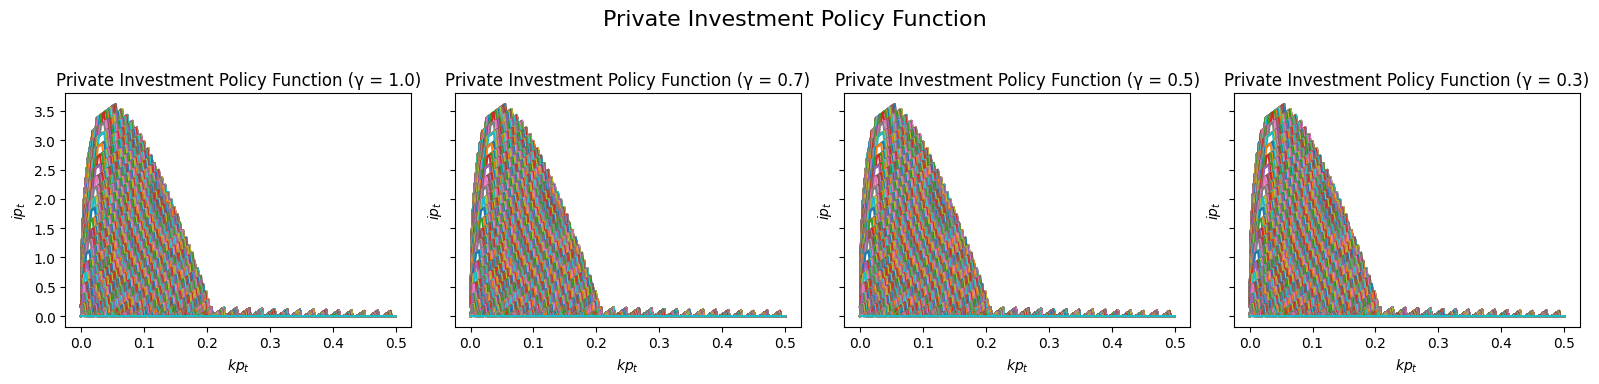

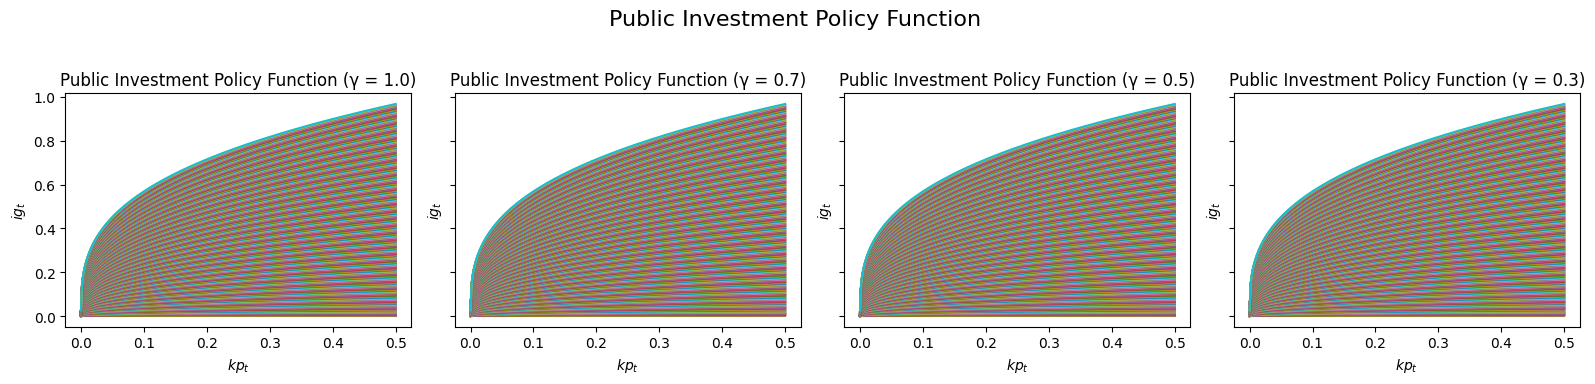

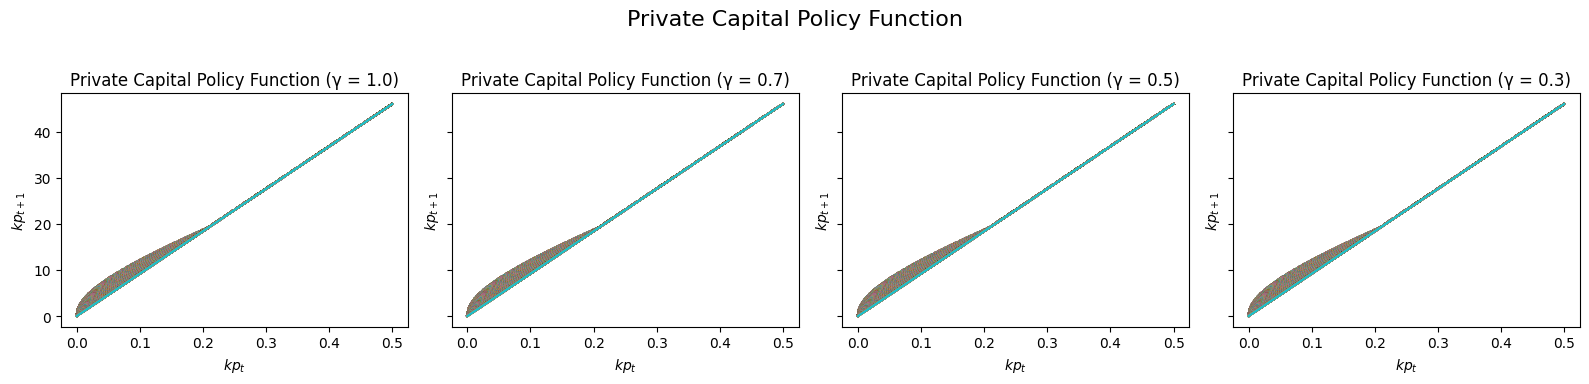

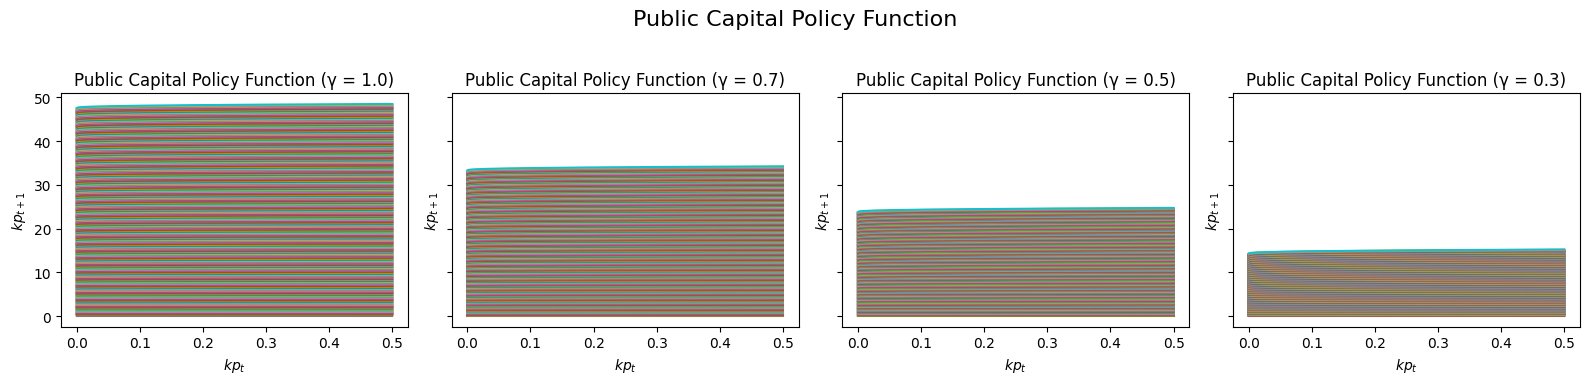

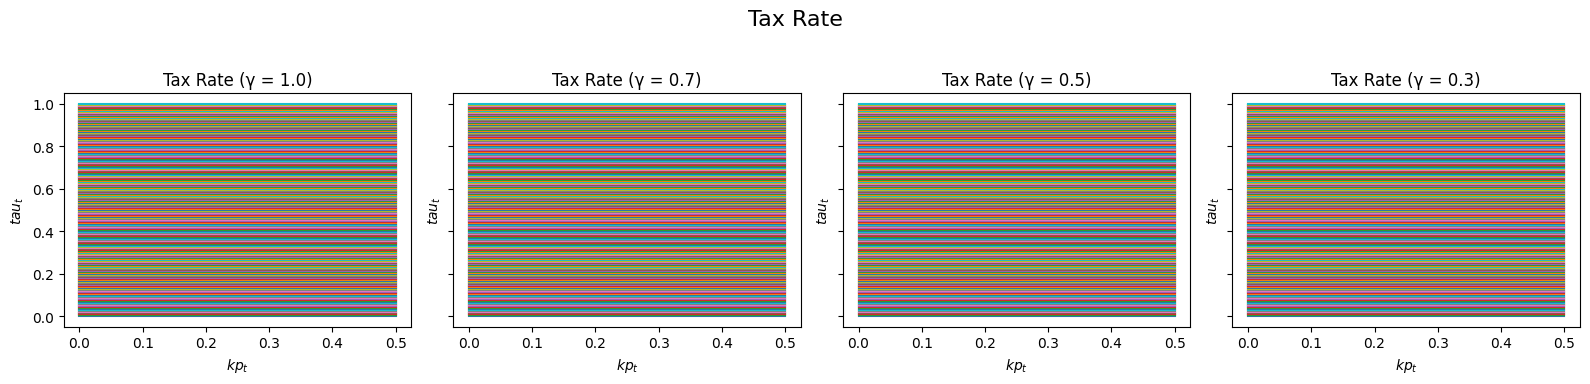

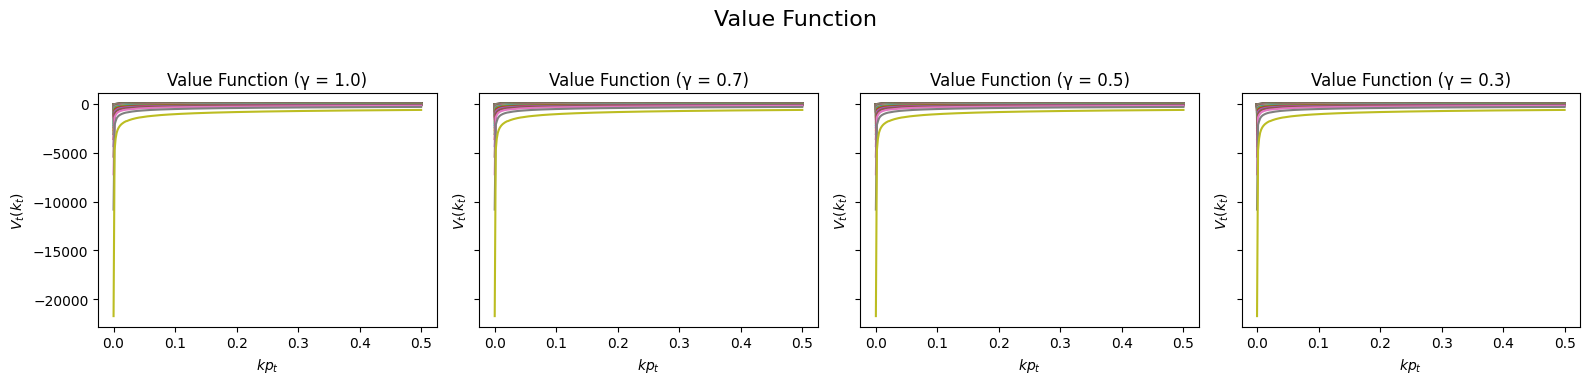

In [ ]:
import matplotlib.pyplot as plt
import contextlib
import io

gamma_list = [1.0, 0.7, 0.5, 0.3]
policy_names = [
    'Output Function',
    'Consumption Function',
    'Private Investment Policy Function',
    'Public Investment Policy Function',
    'Private Capital Policy Function',
    'Public Capital Policy Function',
    'Tax Rate',
    'Value Function'
]

# Create a figure for each policy function
for i, policy_name in enumerate(policy_names):
    fig, axs = plt.subplots(1, len(gamma_list), figsize=(16, 4), sharey=True)

    for j, gamma_val in enumerate(gamma_list):
        # Silence the print outputs temporarily.
        with contextlib.redirect_stdout(io.StringIO()):
            market_forces.setup(gamma=gamma_val)
            live_life_as_normal(market_forces)

        # Only plots will display.
        track_public_capital(market_forces, [axs[j]], gamma_val)

    fig.suptitle(policy_name, fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()